In [1]:
from tensorflow.keras.models import load_model

# loaded_model = load_model('saved_models/NVspin_SimpleRNN_model.h5')
loaded_model = load_model('saved_models/NVspin_LSTM_model.h5')
# loaded_model = load_model('saved_models/NVspin_GRU_model.h5')

2023-08-30 14:08:07.591241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:08:07.641403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-30 14:08:07.642381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 14:08:08.911072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-30 14:08:10.743714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-30 14:08:10.744196: W tensorflow/core/common_r

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
import pandas as pd

# 데이터 불러오기
data = pd.read_csv("data_results/NVspin_LSTM_data_results.csv")

# theta와 phi 값들을 numpy 배열로 변환
thetas = data['Theta'].to_numpy()
phis = data['Phi'].to_numpy()

sum = 0
iter = len(thetas)
num = 0
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

# theta와 phi 값들을 반복하며 fidelity 계산
for target_theta, target_phi in zip(thetas, phis):  
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp
     
     num += 1
     print(num, "/", iter)

print(sum/iter)

1/1 [==============================] - 1s 658ms/step
1 / 17254
1/1 [==============================] - 0s 90ms/step
2 / 17254
1/1 [==============================] - 0s 107ms/step
3 / 17254
1/1 [==============================] - 0s 106ms/step
4 / 17254
1/1 [==============================] - 0s 76ms/step
5 / 17254
1/1 [==============================] - 0s 72ms/step
6 / 17254
1/1 [==============================] - 0s 90ms/step
7 / 17254
1/1 [==============================] - 0s 70ms/step
8 / 17254
1/1 [==============================] - 0s 108ms/step
9 / 17254
1/1 [==============================] - 0s 101ms/step
10 / 17254
1/1 [==============================] - 0s 107ms/step
11 / 17254
1/1 [==============================] - 0s 104ms/step
12 / 17254
1/1 [==============================] - 0s 70ms/step
13 / 17254
1/1 [==============================] - 0s 96ms/step
14 / 17254
1/1 [==============================] - 0s 90ms/step
15 / 17254
1/1 [==============================] - 0s 91ms/step
16 / 

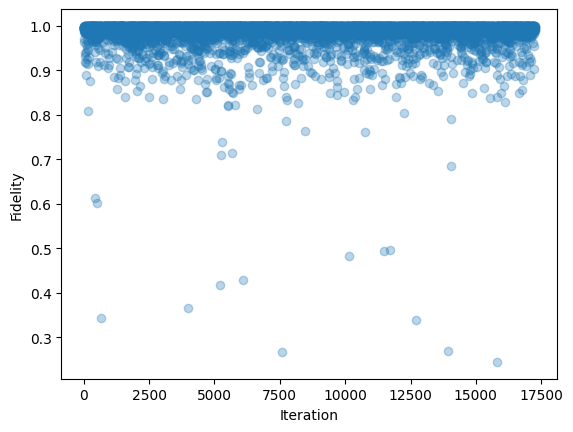

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

6 0.9643572078824638
8 0.9867304888663413
18 0.9709112003475058
28 0.9184133049327121
43 0.9326093146537888
45 0.9387831877984668
47 0.9830814298146687
48 0.9830802588400606
52 0.9889201207349783
54 0.9833201727567009
58 0.988392326255434
65 0.9854378180064525
69 0.9846458248686921
70 0.9867118560046254
79 0.9160022990417093
86 0.9603936855131457
98 0.8896507321659911
102 0.9410421192082699
105 0.981719214074412
115 0.9891878497875018
117 0.9511472264129738
120 0.9889127917457718
125 0.9266027331652974
127 0.9889997132088242
133 0.9886434885045479
134 0.9876315955748798
136 0.9686326641660816
137 0.9837425455441586
145 0.8081181415980649
148 0.946538552377424
150 0.9899091061738781
162 0.985269080382631
172 0.9151262006180455
174 0.9598852758060357
175 0.9800218983766374
176 0.9649852320160746
186 0.9303850787662511
193 0.9891497892840952
201 0.9818933884431142
215 0.9870283274402557
231 0.9846703271912174
234 0.9892846585058106
237 0.9827322941127693
240 0.9846279904052627
244 0.98295

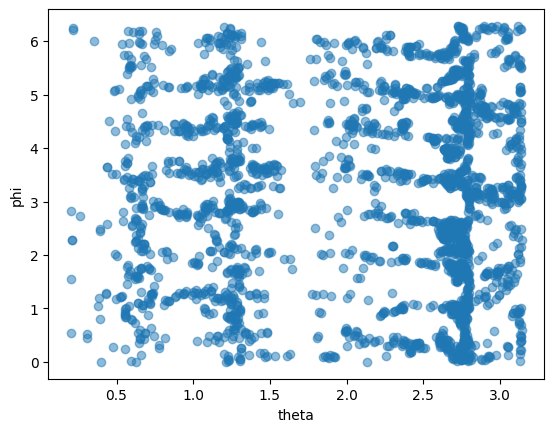

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

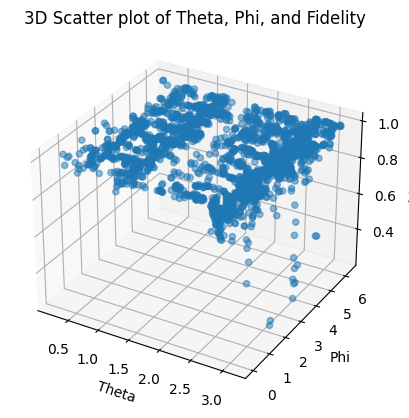

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
